# 3D displacement from asc/desc InSAR & azimuth offset

Need the results from:
1. [prep_az_off.ipynb](./1_prep_az_off.ipynb)
2. [prep_rg_off.ipynb](./2_prep_rg_off.ipynb)
3. [prep_ifgram.ipynb](./3_prep_ifgram.ipynb)

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from skimage.transform import resize
from mintpy.utils import ptime, readfile, writefile, plot as pp, utils as ut
from mintpy.asc_desc2horz_vert import get_design_matrix4east_north_up
from mintpy import view
plt.rcParams.update({'font.size': 12})

S, N, W, E = 33.2, 35.9, 96.6, 100.1
ref_y, ref_x = 2750, 1800

work_dir = os.path.expanduser('~/data/archives/2021MaduoEQ/data')
os.chdir(work_dir)
print('Go to directory:', work_dir)

enu_file = os.path.join(work_dir, 'dis_enu.h5')

Go to directory: /Users/yunjunz/data/archives/2021MaduoEQ/data


## 1. Read (and resize) displacement and geometry

In [2]:
fnames = [
    os.path.join(work_dir, 'SenAT099_20210520_20210526_IFG/geo_filt_msk_ERA5.unw'),
    os.path.join(work_dir, 'SenAT099_20210520_20210526_OFF_AZ/azOffCor.geo'),
    os.path.join(work_dir, 'SenDT106_20210520_20210526_IFG/geo_filt_msk_ERA5.unw'),
    os.path.join(work_dir, 'SenDT106_20210520_20210526_OFF_AZ/azOffCorFilt.geo'),
]
num_file = len(fnames)
atr = readfile.read_attribute(fnames[0])
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
phase2range = float(atr['WAVELENGTH']) / (4.0 * np.pi) * -1

dis_list, inc_angle_list, az_angle_list = [], [], []
for i, fname in enumerate(fnames):
    # read displacement
    dis = readfile.read(fname)[0]
    if fname.endswith('.unw'):
        dis *= phase2range

    # read geometry
    los_file = os.path.join(os.path.dirname(fname), 'los.geo')
    inc_angle = readfile.read(los_file, datasetName='incidenceAngle')[0];  inc_angle[inc_angle == 0] = np.nan
    az_angle  = readfile.read(los_file, datasetName='azimuthAngle')[0];    az_angle[az_angle == 0] = np.nan

    if not fname.endswith('.unw'):
        dis       = resize(dis,       (length, width), order=1, mode='constant', anti_aliasing=True, preserve_range=True)
        inc_angle = resize(inc_angle, (length, width), order=1, mode='constant', anti_aliasing=True, preserve_range=True)
        az_angle  = resize(az_angle,  (length, width), order=1, mode='constant', anti_aliasing=True, preserve_range=True)

    # spatial referencing
    dis -= dis[ref_y, ref_x]

    dis_list.append(dis)
    inc_angle_list.append(inc_angle)
    az_angle_list.append(az_angle)
dis_mat = np.array(dis_list, dtype=np.float32)
inc_angle_mat = np.array(inc_angle_list, dtype=np.float32)
az_angle_mat = np.array(az_angle_list, dtype=np.float32)
del dis_list, inc_angle_list, az_angle_list
print('finished reading data.')

finished reading data.


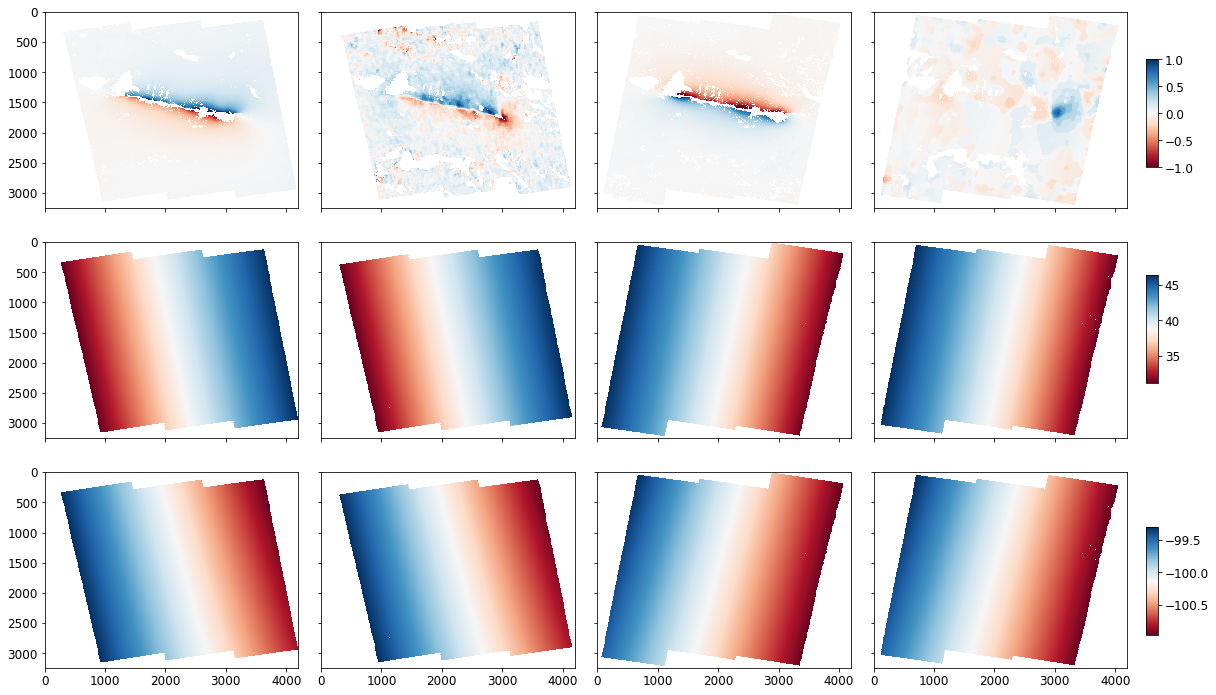

In [3]:
# plot
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=[16, 10], sharex=True, sharey=True)
for i in range(4):
    im1 = axs[0, i].imshow(dis_mat[i,:], vmin=-1, vmax=1, cmap='RdBu', interpolation='nearest')
    im2 = axs[1, i].imshow(inc_angle_mat[i,:], cmap='RdBu', interpolation='nearest')
    im3 = axs[2, i].imshow(az_angle_mat[i,:],  cmap='RdBu', interpolation='nearest')
fig.tight_layout()

# axis format
caxs = [fig.add_axes([1.0, 0.75, 0.01, 0.15]),
        fig.add_axes([1.0, 0.45, 0.01, 0.15]),
        fig.add_axes([1.0, 0.10, 0.01, 0.15])]
for im, cax in zip([im1, im2, im3], caxs):
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
plt.show()

## 2. Estimate 3D displacement field

In [6]:
obs_direction = np.array(['range', 'azimuth', 'range', 'azimuth'])
## mean geometry
#G = get_design_matrix4east_north_up(los_inc_angle=np.nanmedian(inc_angle_mat, axis=(1,2)),
#                                    los_az_angle=np.nanmedian(az_angle_mat, axis=(1,2)),
#                                    obs_direction=obs_direction)
#dis_enu = np.dot(np.linalg.pinv(G), dis_mat.reshape(num_file, -1)).reshape(3, length, width)

# pixel-wise geometry with step
dis_enu = np.zeros((3, length, width), dtype=np.float32) * np.nan
step = 20
num_row = np.ceil(length / step).astype(int)
num_col = np.ceil(width / step).astype(int)
prog_bar = ptime.progressBar(maxValue=num_row)
for i in range(num_row):
    y0, y1 = step * i, min(step * (i + 1), length)
    for j in range(num_col):
        x0, x1 = step * j, min(step * (j + 1), width)
        los_inc_angle = np.nanmedian(inc_angle_mat[:, y0:y1, x0:x1], axis=(1,2))
        los_az_angle = np.nanmedian(az_angle_mat[:, y0:y1, x0:x1], axis=(1,2))
        if np.all(~np.isnan(los_inc_angle)):
            G = get_design_matrix4east_north_up(los_inc_angle, los_az_angle, obs_direction)
            dis_enu_ij = np.dot(np.linalg.pinv(G), dis_mat[:, y0:y1, x0:x1].reshape(num_file, -1))
            dis_enu[:, y0:y1, x0:x1] = dis_enu_ij.reshape(3, y1-y0, x1-x0)
    prog_bar.update(i+1, every=1, suffix=f'{i+1} / {num_row}')
prog_bar.close()

[==================================================] 162 / 162   35s /     0s 


### a. Write result to HDF5 file

In [9]:
# write to HDF5 file
ds_dict = {'east'  : dis_enu[0].reshape(length, width),
           'north' : dis_enu[1].reshape(length, width),
           'up'    : dis_enu[2].reshape(length, width)}
atr['FILE_TYPE'] = 'displacement'
atr['DATA_TYPE'] = 'float32'
atr['UNIT'] = 'm'
atr['BANDS'] = '3'
atr['REF_Y'], atr['REF_X'] = ref_y, ref_x
atr['REF_LAT'], atr['REF_LON'] = ut.coordinate(atr).radar2geo(ref_y, ref_x)[:2]
writefile.write(ds_dict, enu_file, metadata=atr)

delete exsited file: /Users/yunjunz/data/archives/2021MaduoEQ/data/dis_enu.h5
create HDF5 file: /Users/yunjunz/data/archives/2021MaduoEQ/data/dis_enu.h5 with w mode
create dataset /east  of float32    in size of (3240, 4200)         with compression=None
create dataset /north of float32    in size of (3240, 4200)         with compression=None
create dataset /up    of float32    in size of (3240, 4200)         with compression=None
finished writing to /Users/yunjunz/data/archives/2021MaduoEQ/data/dis_enu.h5


'/Users/yunjunz/data/archives/2021MaduoEQ/data/dis_enu.h5'

### b. Quality check

save figure to file /Users/yunjunz/data/archives/2021MaduoEQ/data/dis_enu.png


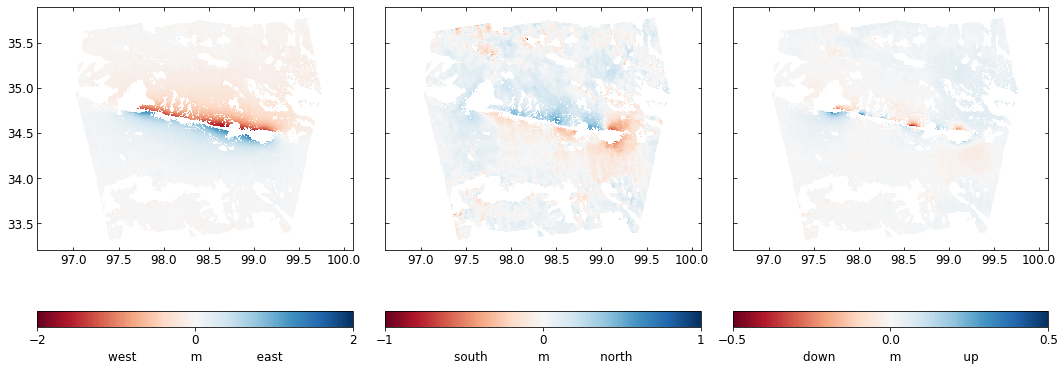

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 6], sharex=True, sharey=True)
kwargs = dict(extent=(W, E, S, N), cmap='RdBu', interpolation='nearest')
vlims = [2, 1, 0.5]
im1 = axs[0].imshow(dis_enu[0,:].reshape(length, width), vmin=-vlims[0], vmax=vlims[0], **kwargs)
im2 = axs[1].imshow(dis_enu[1,:].reshape(length, width), vmin=-vlims[1], vmax=vlims[1], **kwargs)
im3 = axs[2].imshow(dis_enu[2,:].reshape(length, width), vmin=-vlims[2], vmax=vlims[2], **kwargs)
ims = [im1, im2, im3]
labels = ['west              m              east',
          'south             m             north',
          'down              m                up']
for i, (ax, im, label, vlim) in enumerate(zip(axs, ims, labels, vlims)):
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=[-vlim, 0, vlim])
    cbar.set_label(label)
fig.tight_layout()
for ax in axs:
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)

# output
out_fig = os.path.abspath('dis_enu.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()